In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from argparse import ArgumentParser
import sqlite3
from os import path
import pandas as pd
from filter import Filter

def load_dataset(location):
    connection = sqlite3.connect(location)

    df = pd.read_sql("SELECT * FROM feedbacks left join items on feedbacks.item_hash = items.item_hash", connection)
    # remove duplicated columns
    df = df.loc[:, ~df.columns.duplicated()]
    # convert bytestrings
    df['giver_hash'] = df['giver_hash'].str.decode("utf-8")
    df['receiver_hash'] = df['receiver_hash'].str.decode("utf-8")
    df['vendor_hash'] = df['vendor_hash'].str.decode("utf-8")
    # convert timestamps
    df['date'] = pd.to_datetime(df['date'])
    df['first_observed'] = pd.to_datetime(df['first_observed'])
    df['last_observed'] = pd.to_datetime(df['last_observed'])
    # close connection
    connection.close()

    return df

df = load_dataset('dataset/underground_cyber.sqlite3')
df = Filter.apply_all_filters(df)

Size before filter: 564204
Size after filtering custom listing: 560002
Size after filtering drugs: 544942
Size after filtering misc: 542799
Size after filtering guns: 541419


In [121]:
df_bm = pd.read_csv('dataset/bm.csv')[['date', 'count']]
df_bm['date'] = pd.to_datetime(df['date'])
df_bm = df_bm.sort_values(by='date').reset_index(drop=True).dropna()
df_bm['date'] = pd.DatetimeIndex(df_bm['date']).to_period('M')
df_bm = df_bm.groupby('date').sum()
df_bm

,count
date,
2011-09,296
2011-10,352
2011-11,636
2011-12,1181
2012-01,1215
...,...
2017-01,3867
2017-02,2321
2017-03,3543


In [133]:
# Total revenue per month
df_rev = df[['date', 'total_sales']].copy()
df_rev['date'] = pd.DatetimeIndex(df_rev['date']).to_period('M')
df_rev = df_rev.sort_values(by='date')
df_rev = df_rev.groupby('date').sum()
df_rev = df_rev[df_rev.index.isin(df_bm.index)]
df_rev

,total_sales
date,
2011-09,6.294461e+05
2011-10,4.636198e+05
2011-11,4.565829e+05
2011-12,4.991680e+05
2012-01,1.979368e+06
...,...
2017-01,1.259526e+08
2017-02,1.500545e+08
2017-03,1.577099e+08


In [136]:
# Coverage of "black market"
df_bm2 = df_bm.copy()
df_bm2['sales'] = df_rev['total_sales']
df_bm2

,count,sales
date,,
2011-09,296,6.294461e+05
2011-10,352,4.636198e+05
2011-11,636,4.565829e+05
2011-12,1181,4.991680e+05
2012-01,1215,1.979368e+06
...,...,...
2017-01,3867,1.259526e+08
2017-02,2321,1.500545e+08
2017-03,3543,1.577099e+08


In [138]:
df_bm2.corr(method='kendall')

,count,sales
count,1.000000,0.360127
sales,0.360127,1.000000


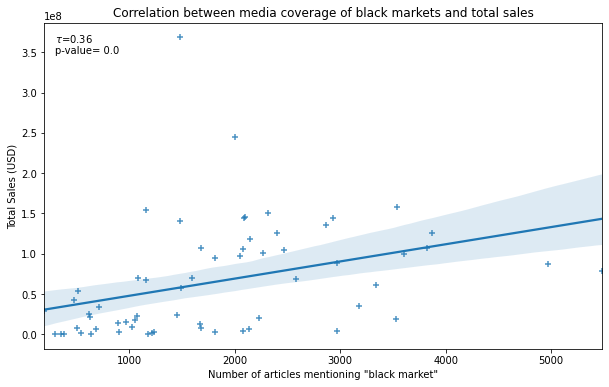

In [185]:
from scipy import stats
from seaborn import regplot
import matplotlib.pyplot as plt
x = df_bm2['count'].tolist()
y = df_bm2['sales'].tolist()
corr, p_value = stats.kendalltau(x, y)
plt.figure(figsize=(10,6))
ax = regplot(x=x, y=y, marker="+")
ax.set(xlabel='Number of articles mentioning "black market"', ylabel='Total Sales (USD)', title='')

ax.set_title('Correlation between media coverage of black markets and total sales')
ax.text(300, max(y)-20000000, r'$\tau$=' + str(round(corr, 2)) + '\np-value= ' + str(round(p_value, 2)))

plt.savefig('mediacoverage_corr.pdf')

plt.show()